# Nvidia & AMD - Analysis on Risk & Return
_Which stock is more valuable to invest into?_

## Context
Our friend saved up a significant amount of money during her freelancing efforts and wants to make an investment of 5.000€ into the stock market. She wants to set her bet on either the NVIDIA (_NVDA_) or AMD (_AMD_) stock as she is convinced that the upcoming Earnings Calls of both graphics chip market will bring a profitable growth in value. As companies are in competition, she assumes that only one of them will come out as a successor. So, to secure a positive return, she only wants to invest into the more promising one of them.

Another factor for our friend is that the potential total loss of her investment should not be over 20%. If the targeted assets are as volatile to bring a higher fluctuation than that, she would like to look for an alternative strategy instead. 
She cannot afford an expensive investment manager and therefore relies on the findings that be derived from the past behaviour of the stocks.
## Goal
Between the stocks of the two chip manufacturers AMD (_AMD_) and NVIDIA (_NVDA_), which one serves as a more risk-free investment if the total tolerance of loss is at 20% of the investment value based on historical data?

## Data
Available are time-series on the historical data of AMD (_AMD_), NVIDIA (_NVDA_) as well as Intel Corporation (_INTC_) as a potential comparison later down the road. All datasets are stored as a CSV, with a covering timespan from Apr. 13 2016 - Apr. 12 2021 (5 years).

## Analysis
### Setup


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
from scipy import stats

amd = pd.read_csv("./datasets/AMD.csv")
nvidia = pd.read_csv("./datasets/NVDA.csv")
intel = pd.read_csv("./datasets/INTC.csv")

combined = amd.assign(Stock="AMD").append(nvidia.assign(Stock="NVIDIA")).append(intel.assign(Stock="Intel"))

# adjust Date column to datetime standard
combined["Date"] = pd.to_datetime(combined["Date"])

# set index and sort by latest entry first
combined = combined.set_index(["Stock", "Date"]).sort_index(axis=0, level=1, ascending=True)

## Descriptive review of Data
The structure of our dataframes looks as following.

In [2]:
print(combined.head())

                        Open       High        Low      Close  Adj Close  \
Stock  Date                                                                
AMD    2016-04-13   2.780000   2.820000   2.730000   2.800000   2.800000   
Intel  2016-04-13  31.969999  32.180000  31.950001  32.130001  28.164856   
NVIDIA 2016-04-13  36.000000  36.750000  36.000000  36.740002  36.079113   
AMD    2016-04-14   2.770000   2.790000   2.700000   2.720000   2.720000   
Intel  2016-04-14  31.780001  31.889999  31.549999  31.799999  27.875582   

                     Volume  
Stock  Date                  
AMD    2016-04-13   8048000  
Intel  2016-04-13  19968100  
NVIDIA 2016-04-13   8767900  
AMD    2016-04-14   8985300  
Intel  2016-04-14  21620900  


Each row documents a trading-day of the stock in each year. 
* The `Date` column holds the date of the trading-day. 
* `High` and `Low` describe the highest/lowest stock value in the timeframe of the day. 
* `Open` indicates the stock value in the beginning of the day (market open), while `Close` holds the terminating value at the end of the day (market close). 

Adjustments can be made to the price on close due to [various factors](https://www.investopedia.com/terms/a/adjusted_closing_price.asp) as a stock split. It is therefore common to provide a an *adjusted closing price* for historical stock data analysis. We will not go into the details of the factors for this value, but proceed with the assumption that the *adjusted closing price* is the most precise value to work with for a long-term analysis as we aim for. The *adjusted closing price* is stored in the `Adj Close` column.

The `Volume` counts the number of shares traded during `Open` and `Close`. For the 2016-04-07 as an example, 44.281.000 shares have been traded over the course of the trading day.

# Visualizing our Data

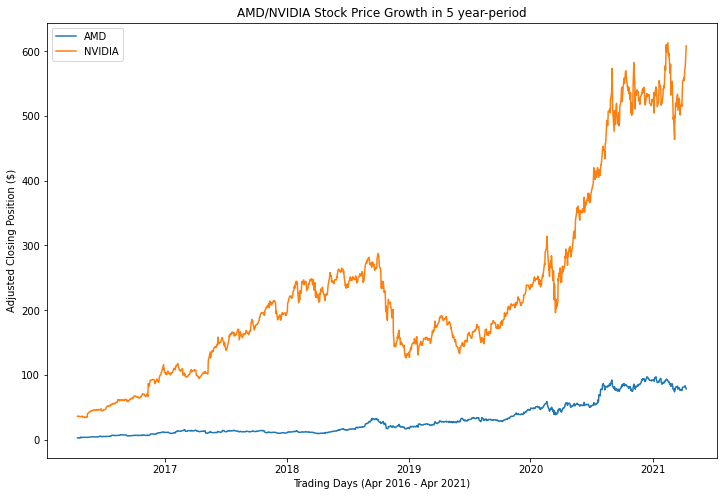

In [3]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(ax=ax, x = "Date", y = "Adj Close", data=combined.loc[["AMD","NVIDIA"]],  hue="Stock").set(xlabel="Trading Days (Apr 2016 - Apr 2021)",ylabel="Adjusted Closing Position ($)");

ax.xaxis.set_major_formatter(md.DateFormatter("%Y"))
plt.legend(loc="upper left")
plt.title("AMD/NVIDIA Stock Price Growth in 5 year-period")

plt.show()

### Visualizing Returns
The stocks in their raw visualization are incomparable, as they have a large difference of value range: AMD's recent value is located between 70-100 US Dollar, while TSLA is located between 500-600 US Dollar.

We therefore determine the daily percental change of the stock adjusted closing value between trading days to better assess and compare the initial impression of volatility, i.e. the change in percental value by day. This lays out the _discrete daily returns_ of our asset. This is relevant for our determination of risk as a high spread of value over time for a stock can be a leading factor to rapid loss (but also: rapid gain).


In [4]:
combined.loc[["AMD"], "Discrete Return"] = combined.loc[["AMD"], "Adj Close"].pct_change()
combined.loc[["NVIDIA"], "Discrete Return"] = combined.loc[["NVIDIA"], "Adj Close"].pct_change()

We can derive fitting limits for our visualization setup for daily returns (e.g. y-limit value) by a brief description of the new column's most relevant statistics.

In [5]:
print(combined.loc[["AMD", "NVIDIA"], "Discrete Return"].groupby("Stock").describe())

         count      mean       std       min       25%       50%       75%  \
Stock                                                                        
AMD     1257.0  0.003424  0.039909 -0.242291 -0.016032  0.001899  0.020718   
NVIDIA  1257.0  0.002704  0.030248 -0.187559 -0.010791  0.002897  0.017246   

             max  
Stock             
AMD     0.522901  
NVIDIA  0.298067  


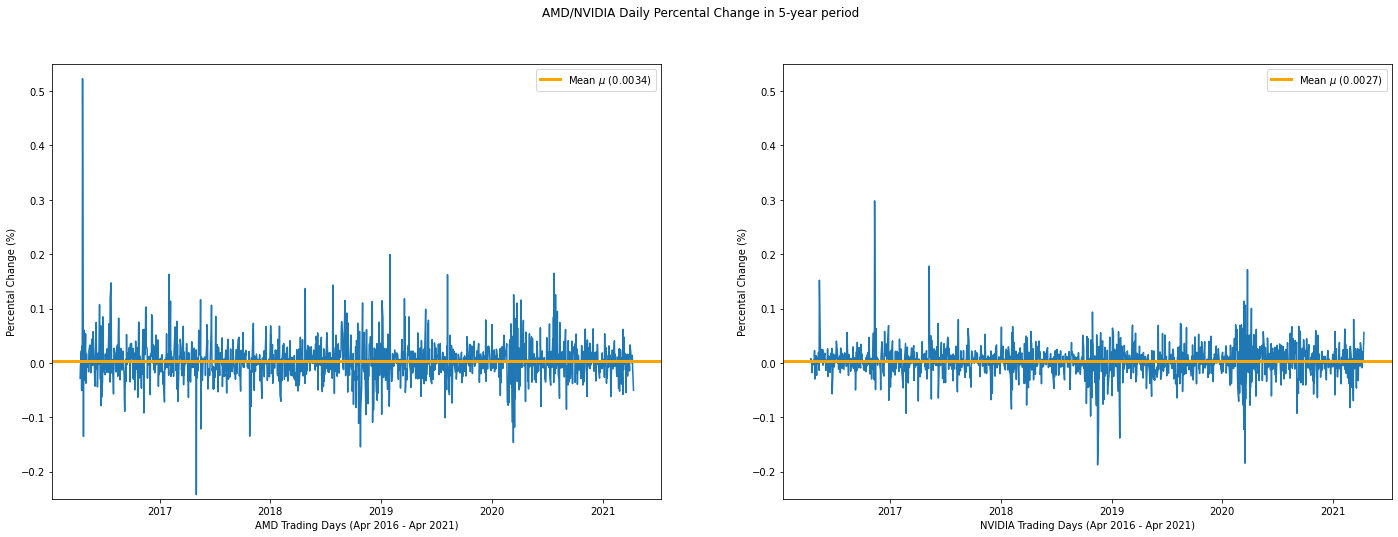

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(24,8))
sns.lineplot(x = "Date", y = "Discrete Return", data=combined.loc[["AMD"]], ax=ax[0])
sns.lineplot(x = "Date", y = "Discrete Return", data=combined.loc[["NVIDIA"]], ax=ax[1])

# describe axes
ax[0].set(xlabel="AMD Trading Days (Apr 2016 - Apr 2021)", ylabel="Percental Change (%)")
ax[1].set(xlabel="NVIDIA Trading Days (Apr 2016 - Apr 2021)", ylabel="Percental Change (%)")

# define same y-limits (by previous statistical description: -0.25 ~ 0.55)
ax[0].set_ylim(-0.25,0.55)
ax[1].set_ylim(-0.25,0.55)

# display mean as horizontal line
ax[0].axhline(y=combined.loc[["AMD"], "Discrete Return"].mean(), linewidth=3.0, color="orange", label="Mean $\mu$ (" + str(combined.loc[["AMD"], "Discrete Return"].mean().round(4)) + ")")
ax[1].axhline(y=combined.loc[["NVIDIA"], "Discrete Return"].mean(), linewidth=3.0, color="orange", label="Mean $\mu$ (" + str(combined.loc[["NVIDIA"], "Discrete Return"].mean().round(4)) + ")")

# add x-axis description
ax[0].xaxis.set_major_formatter(md.DateFormatter("%Y"))
ax[1].xaxis.set_major_formatter(md.DateFormatter("%Y"))

# add legend
ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")

fig.suptitle("AMD/NVIDIA Daily Percental Change in 5-year period");
plt.show()

This looks like a better visualization to compare both stocks' growth. Unfortunately, the one outlier in early 2016 for AMD (from our previous statiscal description the max-value: 0.522901) is stretching our visualization unnecessarily wide. To focus on the relevant data points, we can reduce our visualizations to the data that falls into the 95% confidence level. We can derive this data by using `DataFrame.quantile`. Let us use AMD's values in the following for the quantile determination as it features the strongest outliers at the maximum. 

In [7]:
qi95 = combined.loc[["AMD"], "Discrete Return"].quantile([0.025, 0.975]) # peripheral 5% left out 
print(qi95)

0.025   -0.070786
0.975    0.084461
Name: Discrete Return, dtype: float64


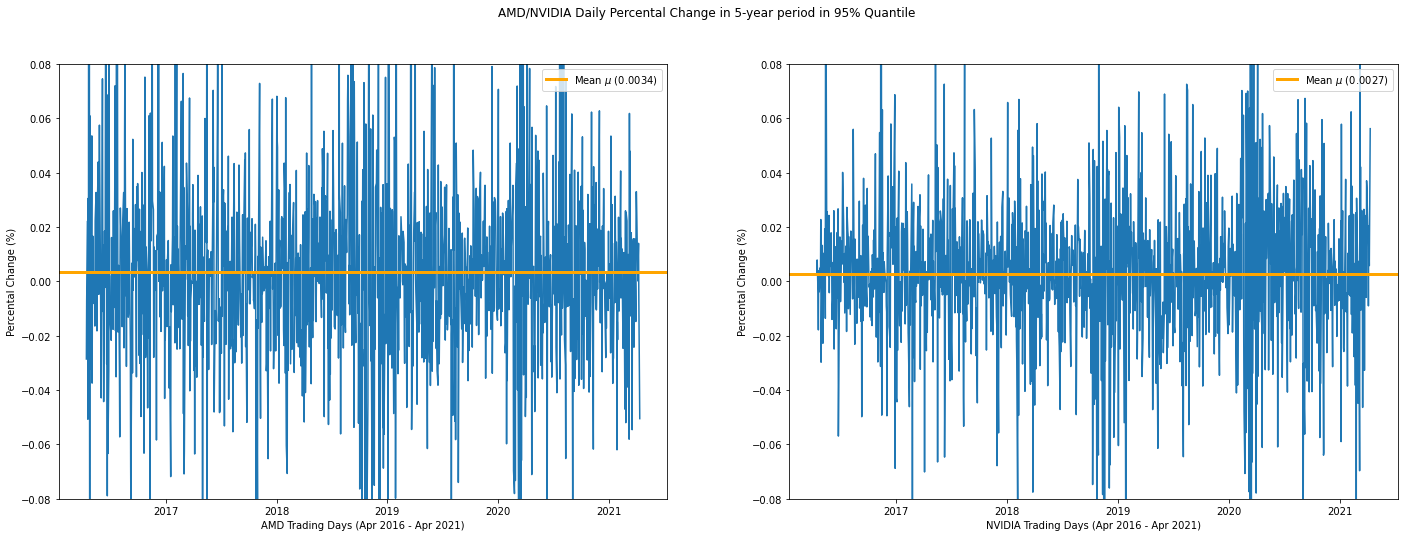

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(24,8))
sns.lineplot(x = "Date", y = "Discrete Return", data=combined.loc[["AMD"]], ax=ax[0])
sns.lineplot(x = "Date", y = "Discrete Return", data=combined.loc[["NVIDIA"]], ax=ax[1])

# describe axes
ax[0].set(xlabel="AMD Trading Days (Apr 2016 - Apr 2021)", ylabel="Percental Change (%)")
ax[1].set(xlabel="NVIDIA Trading Days (Apr 2016 - Apr 2021)", ylabel="Percental Change (%)")

# define new y-limits (by 95% quantile: -0.08 ~ 0.08)
ax[0].set_ylim(-0.08,0.08)
ax[1].set_ylim(-0.08,0.08)


# display mean as horizontal line
ax[0].axhline(y=combined.loc[["AMD"], "Discrete Return"].mean(), linewidth=3.0, color="orange", label="Mean $\mu$ (" + str(combined.loc[["AMD"], "Discrete Return"].mean().round(4)) + ")")
ax[1].axhline(y=combined.loc[["NVIDIA"], "Discrete Return"].mean(), linewidth=3.0, color="orange", label="Mean $\mu$ (" + str(combined.loc[["NVIDIA"], "Discrete Return"].mean().round(4)) + ")")

# add x-axis description
ax[0].xaxis.set_major_formatter(md.DateFormatter("%Y"))
ax[1].xaxis.set_major_formatter(md.DateFormatter("%Y"))

# add legend
ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")

# define new title
fig.suptitle("AMD/NVIDIA Daily Percental Change in 5-year period in 95% Quantile");
plt.show()

Hmm, the quantile span of 95% of the data appears to be eliminating all relevant outliers we discovered in the previous visualization. If we want to build a forecasting model for the volatility of a stock, this would be diserable: Limiting the train data for our model to a reasonable quantile (e.g. 95%) ensures that our model is not training against rare extreme outliers (for stocks mostly caused by unforeseeable economical or political events). We prevent our model to be overfitted.

For our mere interest for visualization instead, we want to feature a maximum tolerance for outliers in our visualization as exactly the outliers are the interesting part of a stock value growth potential. We want to get an overview of the moderate and extreme swings of a stock's value. The inclusion of the extremest outliers in this context is beneficial for this. We should therefore try out visualizations with a wider quantile.

What would be included if we try a 99% interval instead?

In [9]:
qi99 = combined.loc[["AMD"], "Discrete Return"].quantile([0.005, 0.995]) # peripheral 1% left out 
print(qi99)

0.005   -0.116255
0.995    0.141530
Name: Discrete Return, dtype: float64


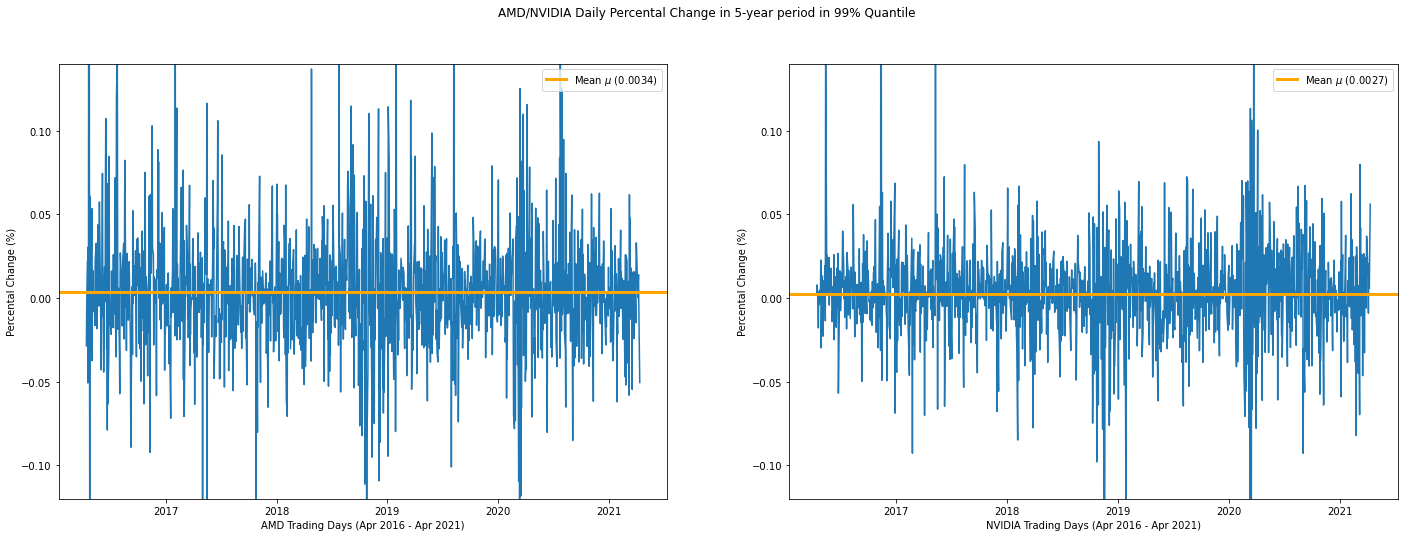

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(24,8))
sns.lineplot(x = "Date", y = "Discrete Return", data=combined.loc[["AMD"]], ax=ax[0])
sns.lineplot(x = "Date", y = "Discrete Return", data=combined.loc[["NVIDIA"]], ax=ax[1])

# describe axes
ax[0].set(xlabel="AMD Trading Days (Apr 2016 - Apr 2021)", ylabel="Percental Change (%)")
ax[1].set(xlabel="NVIDIA Trading Days (Apr 2016 - Apr 2021)", ylabel="Percental Change (%)")

# define new y-limits (by 99% quantile: -0.12 ~ 0.14)
ax[0].set_ylim(-0.12,0.14)
ax[1].set_ylim(-0.12,0.14)


# display mean as horizontal line
ax[0].axhline(y=combined.loc[["AMD"], "Discrete Return"].mean(), linewidth=3.0, color="orange", label="Mean $\mu$ (" + str(combined.loc[["AMD"], "Discrete Return"].mean().round(4)) + ")")
ax[1].axhline(y=combined.loc[["NVIDIA"], "Discrete Return"].mean(), linewidth=3.0, color="orange", label="Mean $\mu$ (" + str(combined.loc[["NVIDIA"], "Discrete Return"].mean().round(4)) + ")")

# add x-axis description
ax[0].xaxis.set_major_formatter(md.DateFormatter("%Y"))
ax[1].xaxis.set_major_formatter(md.DateFormatter("%Y"))

# add legend
ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")

# define new title
fig.suptitle("AMD/NVIDIA Daily Percental Change in 5-year period in 99% Quantile");
plt.show()

This paints a bit more visible picture of the variance, but even this 99% quantile is not allowing us to include the valuable strong outliers visually. 

Let us try one last time with a 99.9% quantile.

In [11]:
qi999 = combined.loc[["AMD"], "Discrete Return"].quantile([0.0005, 0.9995]) # peripheral 0.1% left out 
print(qi999)

0.0005   -0.187129
0.9995    0.319793
Name: Discrete Return, dtype: float64


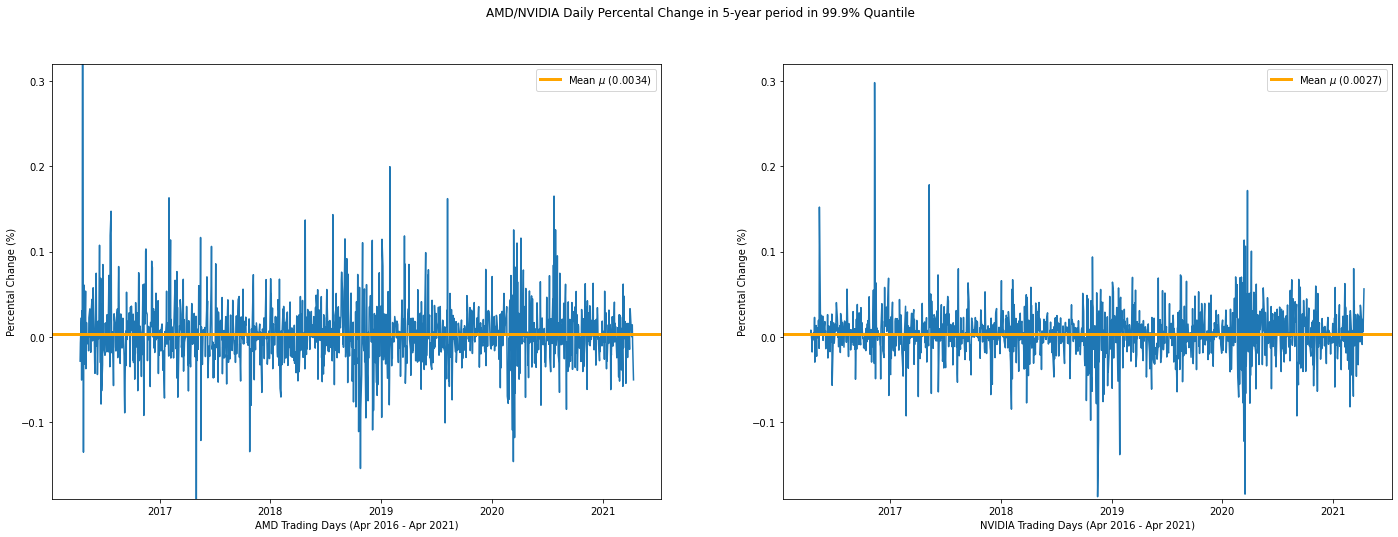

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(24,8))
sns.lineplot(x = "Date", y = "Discrete Return", data=combined.loc[["AMD"]], ax=ax[0])
sns.lineplot(x = "Date", y = "Discrete Return", data=combined.loc[["NVIDIA"]], ax=ax[1])

# describe axes
ax[0].set(xlabel="AMD Trading Days (Apr 2016 - Apr 2021)", ylabel="Percental Change (%)")
ax[1].set(xlabel="NVIDIA Trading Days (Apr 2016 - Apr 2021)", ylabel="Percental Change (%)")

# define new y-limits (by 99.9% quantile: -0.19 ~ 0.32)
ax[0].set_ylim(-0.19,0.32)
ax[1].set_ylim(-0.19,0.32)


# display mean as horizontal line
ax[0].axhline(y=combined.loc[["AMD"], "Discrete Return"].mean(), linewidth=3.0, color="orange", label="Mean $\mu$ (" + str(combined.loc[["AMD"], "Discrete Return"].mean().round(4)) + ")")
ax[1].axhline(y=combined.loc[["NVIDIA"], "Discrete Return"].mean(), linewidth=3.0, color="orange", label="Mean $\mu$ (" + str(combined.loc[["NVIDIA"], "Discrete Return"].mean().round(4)) + ")")

# add x-axis description
ax[0].xaxis.set_major_formatter(md.DateFormatter("%Y"))
ax[1].xaxis.set_major_formatter(md.DateFormatter("%Y"))

# add legend
ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")

# define new title
fig.suptitle("AMD/NVIDIA Daily Percental Change in 5-year period in 99.9% Quantile");
plt.show()

This is a visual that we can work well with. It displays a good overview of the overall fluctuation of the stock's value and highlights that there are significant outliers without warping the visual overview into a far stretch. 

#### Standard Deviation to determine wider spread
From our visuals, AMD _looks_ slightly more volatile, but we can further investigate this impression by visualizing the first standard deviation of both percental change distributions.
By drawing two horizontal lines for the standard deviation and same y-limits on both graphs next to each other, we hopefully have a visual feedback on which stock has a wider daily variance.  

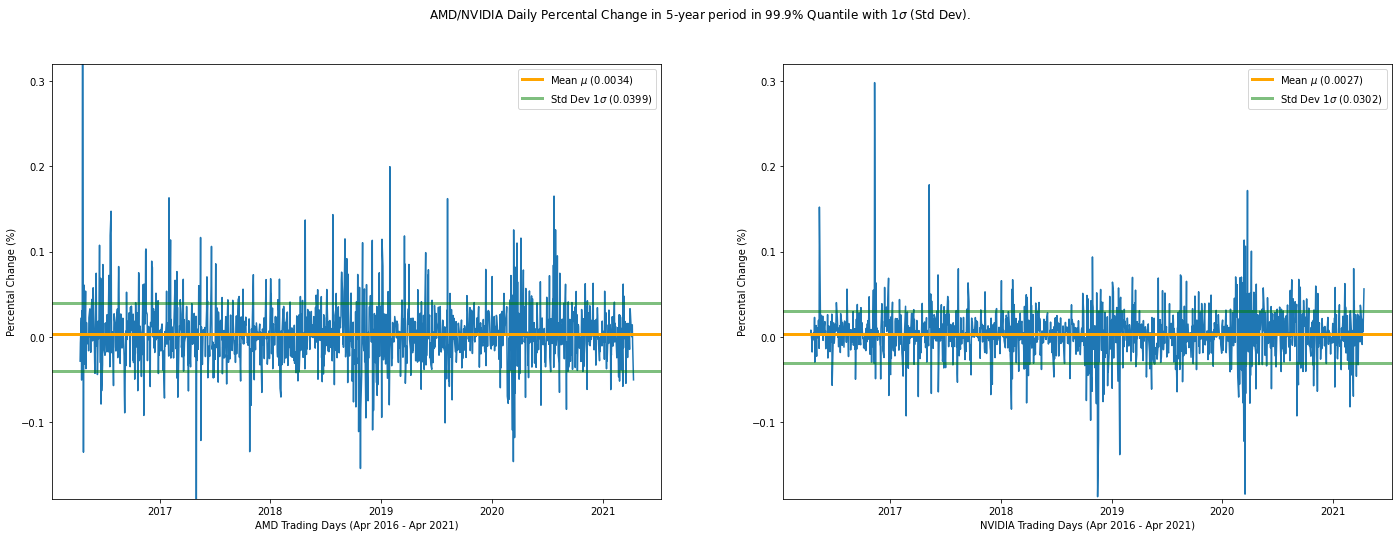

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(24,8))
sns.lineplot(x = "Date", y = "Discrete Return", data=combined.loc[["AMD"]], ax=ax[0])
sns.lineplot(x = "Date", y = "Discrete Return", data=combined.loc[["NVIDIA"]], ax=ax[1])

# describe axes
ax[0].set(xlabel="AMD Trading Days (Apr 2016 - Apr 2021)", ylabel="Percental Change (%)")
ax[1].set(xlabel="NVIDIA Trading Days (Apr 2016 - Apr 2021)", ylabel="Percental Change (%)")

# define y-limits (by 99.9% quantile: -0.19 ~ 0.32)
ax[0].set_ylim(-0.19,0.32)
ax[1].set_ylim(-0.19,0.32)


# display mean as horizontal line
ax[0].axhline(y=combined.loc[["AMD"], "Discrete Return"].mean(), linewidth=3.0, color="orange", label="Mean $\mu$ (" + str(combined.loc[["AMD"], "Discrete Return"].mean().round(4)) + ")")
ax[1].axhline(y=combined.loc[["NVIDIA"], "Discrete Return"].mean(), linewidth=3.0, color="orange", label="Mean $\mu$ (" + str(combined.loc[["NVIDIA"], "Discrete Return"].mean().round(4)) + ")")

# display 1st std as horizontal line
ax[0].axhline(y=combined.loc[["AMD"], "Discrete Return"].std(), linewidth=3.0, color="green", alpha=.5, label ="Std Dev 1${\sigma}$ (" + str(combined.loc[["AMD"], "Discrete Return"].std().round(4)) + ")")
ax[0].axhline(y=combined.loc[["AMD"], "Discrete Return"].std()*(-1), linewidth=3.0, color="green", alpha=.5)
ax[1].axhline(y=combined.loc[["NVIDIA"], "Discrete Return"].std(), linewidth=3.0, color="green", alpha=.5, label ="Std Dev 1${\sigma}$ (" + str(combined.loc[["NVIDIA"], "Discrete Return"].std().round(4)) + ")")
ax[1].axhline(y=combined.loc[["NVIDIA"], "Discrete Return"].std()*(-1), linewidth=3.0, color="green", alpha=.5)

# add x-axis description
ax[0].xaxis.set_major_formatter(md.DateFormatter("%Y"))
ax[1].xaxis.set_major_formatter(md.DateFormatter("%Y"))

# add legend
ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")

# define new title
fig.suptitle("AMD/NVIDIA Daily Percental Change in 5-year period in 99.9% Quantile with 1${\sigma}$ (Std Dev).");
plt.show()

The visualization of the boundries of the first standard deviation ($1{\sigma}$) makes it clear that AMD has a slightly wider daily variance in comparison to NVIDIA.

### Observation $A$: The standard deviation of daily return is higher for AMD.

# Determining Historical Volatility
Volatility is a leading factor for the determination of risk for an investment. In simple terms, the standard deviation of daily variance can be understood as the volatility. As already explored, it states the tendency for fluctuation of an asset's value and therefore the risk for potential rapid or strong loss.
For the advanced determination of a stock's volatility, there are various formulas developed over the centuries to predict historical and implied volatility. _Historical_ volatility determines the fluctuation of an asset's value based on historical, i.e past data. _Implied_ volatility tries to forecast volatility based on supply and demand in the future. Implied volatility is especially interesting for options trading.

Volatility of a stock is time-relevant. Using the entire historical data for a volatility determination is problematic as fluctuation tendencies can change by period in their intensity (heteroskedasticity). Volatility is commonly under the influence of time-based events that are political, social or economical. It is therefore utmost important to frame the respected data for volatility determination into a reasonable recent timeframe. A common frame are the recent 10 - 180 days, depending on the intention and type of asset traded.
For the following calculations, we use a time range of the last 30 trading days.

Let us try to derive the historical volatility with the following simple equation:

### Annualized Parkison Historical Volatility (PHV)
The Parkison formula is one of the simplest formula for volatility determination. It compares the change of daily High and Low values over the course of time. There are other ways to derive the fluctuating behaviour of a stock, as simply comparing Close to Close (Close-to-Close) values, or more advanced equations to count in the night market (Garman-Klaas), bias on opening jumps (Yang-Zhang) and so on. For a simple insight into the volatility, a use of the Parkinson formula will be sufficient.

The equation is as following (http://1.droppdf.com/files/gxQpD/volatility-trading-2013.pdf, p20):

## $\sigma = \sqrt{{1 \over 4Nln2} {\sum_{i=1}^N{(ln {h_{i} \over l_{i}})^2}}}$

where: 
* $N$ is the range of days included (days in time period)
* $h_{i}$ is the _High_ value of day $i$
* $l_{i}$ is the _Low_ value of day $i$

In [14]:
annual_trading_days = 252

def parkinson(data, window, annual_trading_days = 252, annualized= True):
    HL = ((data["High"] / data["Low"]).apply(np.log))**2
    variance = (1 / (4 * np.log(2))) * HL.rolling(window=window).sum()

    def annualize(v):
        return v * (annual_trading_days/window)

    if annualized:
        return np.sqrt(annualize(variance))
    else: return np.sqrt(variance)

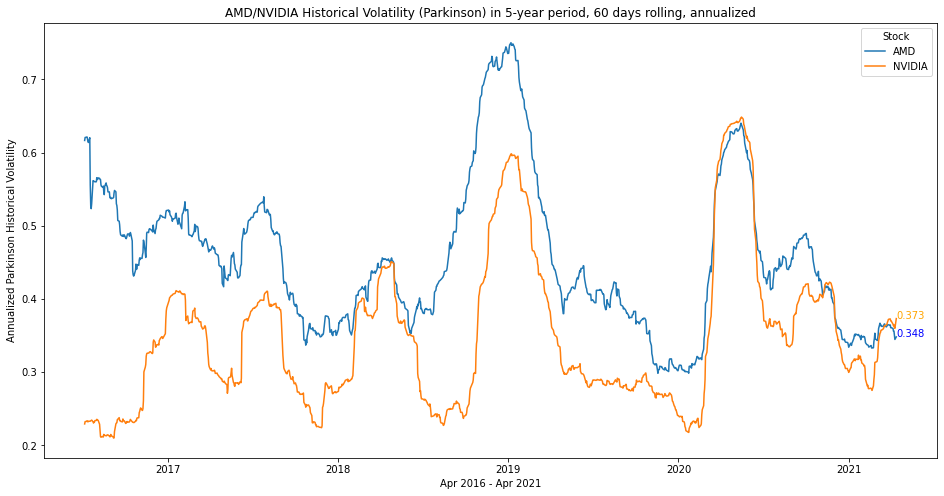

In [15]:
T = 60 # trading days window

# calculate annualized Parkinson Historical Volatility (APHV)
combined.loc[["AMD"], "APHV"] = parkinson(combined.loc[["AMD"]], window=T, annualized=True)
combined.loc[["NVIDIA"], "APHV"] = parkinson(combined.loc[["NVIDIA"]], window=T, annualized=True)

# create plot
fig, line = plt.subplots(figsize= (16, 8))
line = sns.lineplot(x= "Date", y="APHV", hue="Stock", data=combined.loc[["AMD","NVIDIA"]])

# describe axes
line.set(xlabel="Apr 2016 - Apr 2021", ylabel="Annualized Parkinson Historical Volatility")

# describe last data point
amd_last = combined.loc[["AMD"]].iloc[-1:]
nvidia_last = combined.loc[["NVIDIA"]].iloc[-1:]
line.text(x= amd_last.index.get_level_values("Date"), y=amd_last["APHV"], s=np.round(amd_last["APHV"][0],3), color="blue")
line.text(x= nvidia_last.index.get_level_values("Date"), y=nvidia_last["APHV"], s=np.round(nvidia_last["APHV"][0],3), color="orange")

plt.title("AMD/NVIDIA Historical Volatility (Parkinson) in 5-year period, " + str(T) + " days rolling, annualized")

plt.show()

Both assets show a relatively similar looking historical volatility development over the last years. This is to be expected from stable participants of one peer group (computer chip manufacturers). Events as short-comings on resources (e.g. silicon) or Apple cutting ways with AMD and NVIDIA to develop their own M1 chip affects both companies simultaneously.

Peaks sometimes occur with a small delay to another, but both graphs clearly grow and fall together. We can hold the following observation:

### Observation $B$: AMD's and NVIDIA's volatility indicate a similar development.

We can deduct this visually, but we might want to have a exact number for the relationship between the development of both graphs. For this, we can research the _covariance_ of both graphs:



## Correlation Coefficient of AMD & NVIDIA
If variables (in this case: two volatility time-series) move together, we can speak of a _positive_ correlation between them. For movements in an opposite direction, we observe a _negative_ correlation. For our volatility graphs, our attempt is to proof a positive correlation between AMD and NVIDIA's volatility.

The correlation coefficient tells us the strength of the correlation between variables and the direction in which they are correlated. The correlation coefficient can range from +1 to -1. A value towards +1 indicates a positive correlation, i.e. a move into the same direction. A value towards -1 indicates inversed movement. The closer the value to +1 or -1, the more correlated they are. Generally, a correlation coefficient is regarded statisically significant when it reached the +-0.8 threshold. A correlation coefficient of +-0.9 and above is considered very significant. For stocks, the correlation coefficient is mostly used to map out a balanced movement within a portfolio as a few positively and negatively correlated stocks in a portfolio cancel each others moment of correlation growth out. This is desirable for stable low-risk investments. Therefore, a lower correlation coefficient than +-0.8 can be significant for portfolio analysis.

Let's look at the correlation coefficient of AMD and NVIDIA.

In [16]:
corrcoef = np.corrcoef(combined.loc[["AMD"], "Discrete Return"].dropna(), combined.loc[["NVIDIA"], "Discrete Return"].dropna())[0,1]
print("The correlation coefficient of AMD and NVIDIA is:",corrcoef)

The correlation coefficient of AMD and NVIDIA is: 0.5453572109840852


The computed correlation coefficient of +0.545 between the returns of both stocks underscores a notable correlation between both stocks. If AMD goes up, NVIDIA does so too (and same for depreciation). 

## Conclusion $I$: AMD and NVIDIA's historical value evolution is moderately positively correlated.

# Return per Risk
### Simple Risk-Reward-Ratio: The Sharpe Ratio
The easiest method for a first glance on assessing the desirability of one asset to another in terms of risk and reward is the Sharpe Ratio. It was developed in 1966 to compare the expected return of two assets in relation to the implied risk. It is still used today in portfolio risk analysis and significantly contributed to William Sharpe's win of the Nobel Prize in Economics.

The Sharpe Ratio of two assets is best determined in comparison to a shared benchmark. The S&P500 is a popular index that covers the top 500 US equities. Both AMD and NVDA are featured on the S&P 500 and have been a strong contributor in the recent years. The S&P 500 is therefore a well fitting benchmark for a Sharpe Ratio calculation.

#### Setup S&P 500 Index Data
The data provider for the S&P 500 Index is nasdaq.com. The dataset features the same points on `Open`, `Close`, `High` and `Low` values. A `Volume` on the index dataset is not available.
The dataframe will be initiated with the `Date` column as its index.

The dataset is naturally sorted descending by the `Date`. The dataset is reverted to have an order from past to present.

In [17]:
sp500 = pd.read_csv("./datasets/S&P500.csv")

# convert Date column to datetime standard
sp500["Date"] = pd.to_datetime(sp500["Date"])
sp500 = sp500.set_index("Date").sort_index(ascending=True)

# review dataframe structure
sp500.head()


,Close,Volume,Open,High,Low
Date,,,,,
2016-04-13,2082.42,--,2065.92,2083.18,2065.92
2016-04-14,2082.78,--,2082.89,2087.84,2078.13
2016-04-15,2080.73,--,2083.10,2083.22,2076.31
2016-04-18,2094.34,--,2078.83,2094.66,2073.65
2016-04-19,2100.80,--,2096.05,2104.05,2091.68


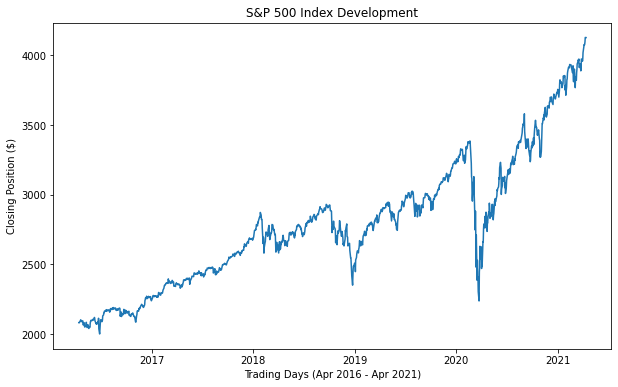

In [18]:
sp500["Datetime"] = pd.to_datetime(sp500.index.get_level_values("Date"))

fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(ax=ax, x = "Datetime", y = "Close", data=sp500).set(xlabel="Trading Days (Apr 2016 - Apr 2021)",ylabel="Closing Position ($)");

ax.xaxis.set_major_formatter(md.DateFormatter("%Y"))
plt.title("S&P 500 Index Development")

plt.show()

#### Percental Daily Discrete Returns
To compare the value development of one asset to another ones value developments, the change of value from day to day has to be relativized. The simplest approach is the comparison of Close-to-Close relation. We have already calculated the discrete return for AMD and NVIDIA. Let us do the same for the S&P 500 Index.

In [19]:
sp500["Discrete Return"] = sp500["Close"].pct_change()

print("S&P 500 Daily Change");
print(sp500["Discrete Return"].tail())
print("\n")
print("AMD & NVIDIA Daily Change (respective to same stock)");
print(combined.loc[["AMD", "NVIDIA"], "Discrete Return"].tail());

S&P 500 Daily Change
Date
2021-04-06   -0.000974
2021-04-07    0.001475
2021-04-08    0.004221
2021-04-09    0.007720
2021-04-12   -0.000196
Name: Discrete Return, dtype: float64


AMD & NVIDIA Daily Change (respective to same stock)
Stock   Date      
NVIDIA  2021-04-06   -0.009008
        2021-04-07    0.020344
        2021-04-08    0.012267
        2021-04-09    0.005797
        2021-04-12    0.056181
Name: Discrete Return, dtype: float64


#### Excess Return AMD/NVIDIA to S&P 500 Index
The percental excess return for AMD/NVIDIA in relation to the S&P 500 index is the difference of percental discrete return of stock to index:

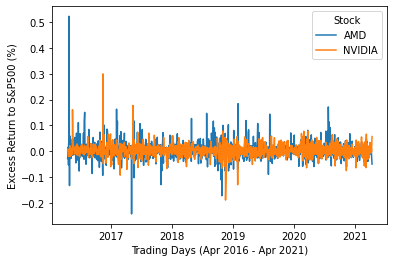

         count      mean       std       min       25%       50%       75%  \
Stock                                                                        
AMD     1257.0  0.002806  0.036221 -0.243480 -0.015425  0.000367  0.017734   
NVIDIA  1257.0  0.002087  0.024785 -0.189782 -0.010149  0.001445  0.013336   

             max  
Stock             
AMD     0.522853  
NVIDIA  0.299465  


In [20]:
combined.loc[["AMD"], "Excess Return SP500"] = combined.loc[["AMD"], "Discrete Return"].sub(sp500["Discrete Return"])
combined.loc[["NVIDIA"], "Excess Return SP500"] = combined.loc[["NVIDIA"], "Discrete Return"].sub(sp500["Discrete Return"])

sns.lineplot(x = "Date", y = "Excess Return SP500", data=combined.loc[["AMD", "NVIDIA"]], hue="Stock").set(xlabel="Trading Days (Apr 2016 - Apr 2021)",ylabel="Excess Return to S&P500 (%)");
plt.show();

print(combined.loc[["AMD", "NVIDIA"], "Excess Return SP500"].groupby("Stock").describe())

### The Sharpe Ratio of AMD/NVIDIA
The Sharpe Ratio is essentially a standardized mean return in relation to the volatility (generally: the standard deviation).
It is defined as following:

### $S(x) = {{({\mu}_{x} - {R}_{f})} \over { {\sigma}_{{r}_{x}} } }$
​
where:
* $S(x)$ is the Sharpe Ratio of $x$
* $x$ is the investment
* ${\mu}_{x}$ is the mean return of $x$
* ${R}_{f}$ is the risk-free return
* ${\sigma}_{{r}_{x}}$ is the standard deviation of the mean of $x$.

The risk-free return ${R}_{f}$ can be neglected in the following context due to multiple reasons. First, the effective interest rate (direct risk-free-ratio factor) on common derivatives for the risk-free ratio (3-month U.S. Treasury Bill, EUR Risk-Free Rate) has rarely been lower than in the recent years compared to the historical development of risk-free returns. Today's risk-free interest rate for the EUR is between 1% to -1% and is therefore mathematically insignifcant for our Sharpe ratio (https://www.venn.twosigma.com/vennsights/the-role-of-the-risk-free-rate). Second, a singular equity investment (e.g. single stock investment as AMD/NVIDIA) does not yield a risk-free rate in practice. (https://www.investopedia.com/terms/r/risk-freerate.asp) A portfolio of equity investments may allow a risk-free return in relation to the mean growth of it's most related index. As we analyse single equity investments here, a risk-free return should not be assumed.

#### Calculation of Sharpe ratio

In [21]:
amd_mean_excess_return = combined.loc[["AMD"], "Discrete Return"].mean()
amd_excess_return_std = combined.loc[["AMD"], "Discrete Return"].std()
amd_sharpe_ratio = amd_mean_excess_return / amd_excess_return_std


nvidia_mean_excess_return = combined.loc[["NVIDIA"], "Discrete Return"].mean()
nvidia_excess_return_std = combined.loc[["NVIDIA"], "Discrete Return"].std()
nvidia_sharpe_ratio = nvidia_mean_excess_return / nvidia_excess_return_std

annualized_amd_sharpe_ratio = amd_sharpe_ratio * np.sqrt(annual_trading_days)
annualized_nvidia_sharpe_ratio = nvidia_sharpe_ratio * np.sqrt(annual_trading_days)

print("AMD's Sharpe-Ratio equals:",annualized_amd_sharpe_ratio)
print("NVIDIA's Sharpe-Ratio equals:", annualized_nvidia_sharpe_ratio)

AMD's Sharpe-Ratio equals: 1.3617769698280615
NVIDIA's Sharpe-Ratio equals: 1.4192150667327752


A higher Sharpe Ratio implies a higher return relative to the volatility. A Sharpe Ratio of 1 and up is an indication of a return proportional to the risk (to the volatility). Therefore, the stock with the highest Sharpe Ratio should be considered as most desirable. In our case, *NVIDIA* wins the bet for best return-per-risk!

## Conclusion $II$: NVIDIA shows a higher return-per-risk by Sharpe Ratio.

# Historical Value at Risk (VaR)

The historical volatility can give us a broad sense of the potential fluctuations and the implied gain/loss on our stock investment. As an investor, the informed choice of a moderately volatile stock can return a fair profit. Simultaneously, volatility is a direct threat for loss. A rapid loss takes time to recover from, implied that the stock's value recovers at all, and so to ensure a predictable value of our assets, investors should define a maximum for their loss tolerance. For our friend, the maximum loss tolerance is at 20% of her investment.

In real life practice, a maximum loss of 20% cannot be ensured. Stocks are differently volatile over the course of time and can depreciate rapidly due to a variety of events. In a consideration of historical development of a stock as a benchmark for future performance, we can analyze the past data and derive a _likelyhood_ for the stock's risk for value depreciation to exceed our investment loss threshold. What we measure is the so called _tail risk_ of a stock - and a good method to quantify it is to estimate the historical _Value at Risk_ (VaR).

### Historical Value at Risk
Value at Risk is a metric that describes if losses will not exceed a certain level in a provided confidence level. Value at Risk results are often accompanied with a more human-friendly written statement, which we will also practice further ahead. 

An example for Value at Risk:

> VaR(99) = -5.7%
>> -> _99% certainty that **losses won't exceed** -5.7% in a given day based on historical data._


In [22]:
def VaR(data, confidence):
    return np.percentile(data.dropna(), (100 - confidence))

In [23]:

confidence_level = 95
amd_HVaR95 = VaR(combined.loc[["AMD"], "Discrete Return"], confidence_level)
nvidia_HVaR95  = VaR(combined.loc[["NVIDIA"], "Discrete Return"], confidence_level)

print("AMD Value at Risk: " + str(confidence_level) + "% certainty that losses will not exceed " + str(np.round(100 * amd_HVaR95, 2)) + "% in one day based on historical data.")
print("NVIDIA Value at Risk: " + str(confidence_level) + "% certainty that losses will not exceed " + str(np.round(100 * nvidia_HVaR95, 2)) + "% in one day based on historical data.")

AMD Value at Risk: 95% certainty that losses will not exceed -5.2% in one day based on historical data.
NVIDIA Value at Risk: 95% certainty that losses will not exceed -4.34% in one day based on historical data.


Great! In simplified words, the probability to lose more than 4.3~5.2% of our investment value in one day is lower than five percent, with NVIDIA offering the better chance for less loss. A 95% confidence level implies a scenario of 5% of worse cases. As humans, especially with our monetary capital, we would like to be extra safe and eliminate as much as risk as possible when making an investment decision. Therefore, let's look at the 99% and 99.9% Value at Risk, too!

In [24]:
confidence_level = 99
amd_HVaR99 = VaR(combined.loc[["AMD"], "Discrete Return"], confidence_level)
nvidia_HVaR99 = VaR(combined.loc[["NVIDIA"], "Discrete Return"], confidence_level)

print("AMD Value at Risk: " + str(confidence_level) + "% certainty that losses will not exceed " + str(np.round(100 * amd_HVaR99, 2)) + "% in one day based on historical data.")
print("NVIDIA Value at Risk: " + str(confidence_level) + "% certainty that losses will not exceed " + str(np.round(100 * nvidia_HVaR99, 2)) + "% in one day based on historical data.")

AMD Value at Risk: 99% certainty that losses will not exceed -9.32% in one day based on historical data.
NVIDIA Value at Risk: 99% certainty that losses will not exceed -7.75% in one day based on historical data.


In [25]:

confidence_level = 99.9
amd_HVaR999 = VaR(combined.loc[["AMD"], "Discrete Return"], confidence_level)
nvidia_HVaR999  = VaR(combined.loc[["NVIDIA"], "Discrete Return"], confidence_level)

print("AMD Value at Risk: " + str(confidence_level) + "% certainty that losses will not exceed " + str(np.round(100 * amd_HVaR999, 2)) + "% in one day based on historical data.")
print("NVIDIA Value at Risk: " + str(confidence_level) + "% certainty that losses will not exceed " + str(np.round(100 * nvidia_HVaR999, 2)) + "% in one day based on historical data.")

AMD Value at Risk: 99.9% certainty that losses will not exceed -15.24% in one day based on historical data.
NVIDIA Value at Risk: 99.9% certainty that losses will not exceed -17.27% in one day based on historical data.


These look like favorable insights for our analysis! we can say with a 99.9% certainty that neither AMD (-15%) nor NVIDIA (-17%) exceed our maximal loss threshold of 20% in one single day. 

An interesting observation is that for the 95% and 99% confidence level, NVIDIA has been favorable with a lower loss rate. For our 99.9% confidence level, AMD appears to be more favorable due to it's lower loss rate of -15%. This indicates that for NVIDIA, the 1st percentile features more or stronger outliers than AMD's 1st percentile. 

We can conclude: For 99.9% of all trading days, both AMD and NVIDIA's stock values do not lose more than 20% . We can say that for a desired high confidence into the loss behaviour of both stocks, AMD is the preferable stock with a slightly lower daily risk of -15% in comparion to -17% of NVIDIA.

When making a statement about the potential loss of a stock's value in a period of time, the consideration of the trading behaviour of the investor is of importance. The above determined Value at Risk statement holds true for a 1-day period. For day-traders (investors that buy and sell stocks over the course of the day), this might be a sufficient risk statement. For our example, the investment is targeted to hold over a medium to long-term period. What can we say about the potential loss in a longer period of time?

Let us, for the sake of the argument, extend our previous defined project context to match this scenario. Our friend expects the value of both stocks to feature potential gains due to the upcoming Earnings Calls of both companies (an event that commonly brings a higher volatility of the respective stock with it). She therefore wants to buy early and hold the investment for a month. 

What we want to communicate to our friend is a _scaled_ Value at Risk based on historical data, which we will further examine in the following.


### Scaled Historical Value at Risk
Just as with volatility, we can scale the value of a one-day time period by multiplying with the square root of time _t_, where _t_ is the amount of days. We already defined that a year has 252 trading days, so to derive an annual VaR, the daily VaR should be multiplied with $\sqrt{252}$.

Let us try to visualize an example of a value -3.6% for VaR(95) at day 1 and see how the confidence in a maximum loss of -3.6% scales for one trading year:

<ipython-input-44-d8df158cfedf>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:.0%}'.format(y/100) for y in ax.get_yticks()])


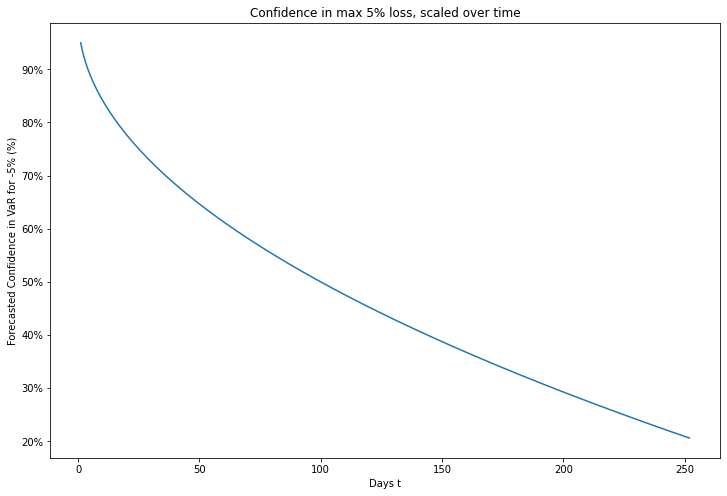

In [44]:
days = 252
VaR95_estimate = -5.0

# Aggregate forecasted VaR
VaR95_forecasts = np.empty([days, 2])

# Loop through each forecast period
for i in range(days):
    # Save the time horizon i
    VaR95_forecasts[i, 0] = i + 1 # start with day 1
    # Save the forecasted VaR 95
    VaR95_forecasts[i, 1] = VaR95_estimate * np.sqrt(i + 1)

fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(ax=ax, x=VaR95_forecasts[:, 0], y=(100 + VaR95_forecasts[:, 1]))
ax.set(xlabel="Days t", ylabel="Forecasted Confidence in VaR for -5% (%)")
ax.set_yticklabels(['{:.0%}'.format(y/100) for y in ax.get_yticks()])

plt.title("Confidence in max 5% loss, scaled over time")
plt.show()

As we can see, due to the square root influence over time, we rapidly lose confidence into a max 5% loss over the first week, but only observe a slow deprecation in confidence over the later days. In the context of the stock market, this makes sense as multiple losses over a short period of time are plausible, implying that the confidence in a stable value over two weeks can quickly drop. Meanwhile, a stock's value often recovers and experiences upsurges over the course of time and thus confidence in a maximum loss over longer periods of time becomes more stable. 

Let us now come back to the Historical Value at Risk on a monthly scale for our friend. What max. loss can we communicate her on a 95% confidence level?

### Monthly Historical Value at Risk
On average, a month feature 21 trading days. This is due to the difference in holidays and weekend days over the course of the year. In the following, we will use this number to scale to monthly values.

In [62]:
monthly_trading_days = 21

confidence_level = 95
amd_HVaR95 = VaR(combined.loc[["AMD"], "Discrete Return"], confidence_level) * np.sqrt(monthly_trading_days)
nvidia_HVaR95  = VaR(combined.loc[["NVIDIA"], "Discrete Return"], confidence_level) * np.sqrt(monthly_trading_days)

print("AMD Value at Risk: " + str(confidence_level) + "% certainty that losses will not exceed " + str(np.round(100 * amd_HVaR95, 2)) + "% in one day based on historical data.")
print("NVIDIA Value at Risk: " + str(confidence_level) + "% certainty that losses will not exceed " + str(np.round(100 * nvidia_HVaR95, 2)) + "% in one day based on historical data.")

AMD Value at Risk: 95% certainty that losses will not exceed -23.84% in one day based on historical data.
NVIDIA Value at Risk: 95% certainty that losses will not exceed -19.88% in one day based on historical data.


For our 95% confidence level, NVIDIA and AMD both fall over our 20% loss threshold on a monthly scale. We are interested to know with which certainty we can guarantee a loss threshold of 20% based on historical data. For that, we could attempt trial and error with various confidence levels until we have found the right one. Alternatively, we can change the equation to determine at which percentile (i.e. our `1 - confidence level`) the closest score under our 20% threshold (-0.2 value in our Discrete Return distribution) falls:

### Determining Confidence for Monthly Historical Value at Risk = 20%
We can derive the confidence level from determining the closest percentile below the threshold (0.2%). We can calculate the named percentile with the following formula:

## $q = {{|x < k|} \over {|x|}}$

where:
* $q$ is the percentile.
* $x$ is the set of values.
* $k$ is the threshold value.
* $|x|$ is the count of values in the set $x$.
* thereby $|x<k|$ is the count of values in the set $x$ that fall under the threshold value $k$.

With this, we can determine the confidence in a max. 20% loss for AMD and NVIDIA:

#### AMD

In [63]:
threshold = -0.20

amd_monthly_returns = combined.loc[["AMD"], "Discrete Return"] * np.sqrt(monthly_trading_days)
q = sum(amd_monthly_returns <= threshold) / len(amd_monthly_returns)

amd_confidence = 1 - q

amd_MHVaR = VaR(combined.loc[["AMD"], "Discrete Return"], amd_confidence) * np.sqrt(monthly_trading_days)

#### NVIDIA

In [64]:
nvidia_monthly_returns = combined.loc[["NVIDIA"], "Discrete Return"] * np.sqrt(monthly_trading_days)
q = sum(nvidia_monthly_returns <= threshold) / len(nvidia_monthly_returns)

nvidia_confidence = 1 - q

nvidia_MHVaR = VaR(combined.loc[["NVIDIA"], "Discrete Return"], nvidia_confidence) * np.sqrt(monthly_trading_days)

In [65]:
print("AMD Monthly Historical Value at Risk: {:.1%}".format(amd_confidence) + " certainty that losses will not exceed more than {:.0%} in one month based on historical data.".format(amd_MHVaR))
print("NVIDIA Monthly Historical Value at Risk: {:.1%}".format(nvidia_confidence) + " certainty that losses will not exceed more than {:.0%} in one month based on historical data.".format(nvidia_MHVaR))

AMD Monthly Historical Value at Risk: 93.0% certainty that losses will not exceed more than 54% in one month based on historical data.
NVIDIA Monthly Historical Value at Risk: 95.0% certainty that losses will not exceed more than 32% in one month based on historical data.


These are quantitative results we can work with. On a monthly scale, based on the past historical data, NVIDIA features a lower chance for a monthly loss higher than 20%.

## Conclusion $III$: NVIDIA has a historically lower chance to exceed a loss higher than 20% over one month.

# Summary & Conclusions
Let us collect our observations and conclusions.

#### Conclusions
Conclusion $I$: AMD and NVIDIA's historical value evolution is moderately positively correlated.

Conclusion $II$: NVIDIA shows a higher return-per-risk by Sharpe Ratio.

Conclusion $III$: NVIDIA has a historically lower chance to exceed a loss higher than 20% over one month.

#### Observations
Observation $A$: The standard deviation of daily return is higher for AMD.

Observation $B$: AMD's and NVIDIA's volatility indicate a similar development.

With historical data, we were able to show that AMD had a higher fluctuation in value over time than NVIDIA. Both stocks share a similar development pattern in growth and depreciation. We can quantify their relation with a correlation coefficient of ~0.54, indicating a positive correlation between both datasets. This is a strong support for our initital assumption that both stocks are part of the same peer group, as furthermore the visualization of their volatilities indicates that both are affected by the same historical events.

In the pursuit of risk-determination, NVIDIA turned out to be the more desirable stock in regards to return-per-risk defined through the Sharpe Ratio. This tendency in NVIDIA's favor is underlined by the higher confidence in a maximum loss threshold of 20% compared to AMD. Both the Sharpe Ratio and Value at Risk estimates are a common factor for risk analysis and comparison and therefore form vital insights to make a preliminary conclusion about the preferability of one of the two stocks. 

**To sum up: Based on the historical data of the last five years, including the intra-day variances of the stock values, NVIDIA is the more promising stock for our investment in regards to simple return-per-risk defined through the Sharpe Ratio with a probability of only 5% to exceed the 20% loss threshold in a period of one month (compared to AMD: 7% exceedance chance).**

## Critique
The approaches to determine the preferability of investment choice as applied above have to discussed. As with all investment choices, the strength of the analysis depends the variety of defining markers, the identifiaction and selection of the relevant markers, as well as in the appropriate weighting of these markers. A uni or bivariate analysis in the domain of stock market investment cannot be considered of reliable significance due it's interrelated nature of various market mechanisms. A quick look on any stock report will highlight the noteworthy variety of different statistics and criteria which are deemed relevant to get a first impression of a stock's value development. It is therefore no coincidence that the attempt to predict the preferability of an investment based on data (e.g. "Quantitative Finance") has become a huge sector in the digital industry. 

A contextual flaw in the above approaches is the focus on determining limits of loss. The approach fails in its analysis to underline the necessity of promising returns, as the target of investment is the gain of _relevant_ value. Thus, a comparison between taken risk and implied profit chances can be better performed by looking at the typical downfalls (depreciations) and the deeper analysis of events promising good returns. To put it into other words: Is taking the decent chance for a 10% loss worth the expected 7% upsurge (as an example provided by an Earnings Call in the past ? A word has to be made about the investment strategy to determine the methods of risk-reward analysis: Is the intention to hold a value steady and accumulate profits moderately (mid- to long-term)? Then an investment with low volatility and equal tendencies to growth and depreciation is favorable. If rather the fast gain of a return is the intention of an investment, the chances for a value upsurge should clearly outweigh the probability of loss.

A word on the assumptions underlying the conclusions about the behaviour of both stocks: The forming of conclusions based on a large frame of historical data implies that all data is equally relevant. This approach assumes that the market stays the same. In reality, the market is _highly_ time-relevant and can take unexpected significant turns within the span of trading hours of just one day. Especially any decision based on the average volatility over large timeframe falls for the illusion that the variance of its values is homogenous, meaning that the variance between the data points is the same across all observations throughout the time-series. A homogeneity of a stock's variance, or in the market terms a _homoskedasticity_, cannot be found in either of our example stocks (AMD & NVIDIA). A visual proof of this can be found in the graphs for Percental Change. AMD and NVIDIA are marked of periods of high volatility and a retreat into less volatile times: The stock's variance is heteroskedastic. These fractions of high volatility timeframes (called volatility clusters) are often induced through autoregression of stock's own volatility development. The detailed nature of this behaviour outgrows the scope of this critique, but it is worth to note that a general practice for volatility analysis is the determination of autoregression and heteroskedastic tendency of a stock. Autoregressive Conditonal Heteroskedasticity (ARCH) models have been developed to allow forecasts to be made with these factors in mind (see `courses/datacamp--garch-models`).

Another noteworthy critique on the above used methods is the application of Value at Risk estimates based on Day 1 values on the long-term scale. The Value at Risk estimate for day X includes all data points prior to day X to determine the percentile for the provided confidence level. For a reasonable estimate for Day 200, all data points between Day 1 and Day 200 must be included into the estimate. What is necessary is a _moving_/dynamic Value at Risk estimate. In the above application for a monthly value, this conflict does not stand out. If we assume an annualized estimate instead, the relevance of the values between Day 0 and Day 252 (one trading year) becomes clearer. As these data points for future values are obviously not accessible, such an estimate requires a forecasting model to be in place. Lastly, the current estimate of Value at Risk includes all data points from the last five years. The question has to be raised: Which data points are relevant for an estimate for future investments? The need for such concern becomes clear with the example of the Tesla stock: Until two and a half years ago, the Tesla stock has only shown moderate fluctuations, while recent changes in the stock have shown an extreme upsurge in value and volatility. This is due to the recent successes and growth of the company. If we were to include the last five years, our estimate would run against a great portion of "deprecated" data - the past data represents a company that is "not existing" anymore. 

## Reflection
Looking back on the progress of this project, the scope and approach definitely changed more than I had anticipated! This project started out to be just on of the projects for my Data Science portfolio. The initial goal for this project was to allow me implement all the basic to advanced financial concepts I have learned over the semester. Once I discovered that this will be my main project for this semester, my approach to the scope of it has shifted significantly. I had to ask myself a few questions: What is it that I want to find out? Where was I heading before? Is there a specific message I feel inclined to convey (i.e. a bias)? What do I feel competent to analyze appropriately? To find answers to these questions, the guideline on Notion on how to form my own Data Science project was really helpful. I appended the first draft of my project outline in the `outline.md` file. Reviewing my initial goals, I can say that I underestimated the difficulty to highlight relevant data in what I considered "simple questions, simple answers", for example the proper visualization of volatility differences between both stocks. Furthermore, I included methods and questions I wanted to answer (e.g. performing an exhaustive value forecast with ARCH models) that stretched the scope of the project way too far: I couldn't justify fitting all things I wanted to show under _one_ major concern and thus, I felt the need to reduce the project to fewer subquestions that all cotribute to answer the overarching question. Further into exploring my options, I have discovered that my initial question had to be modified: I was only working with historical data, and I was deriving conclusions on the profitability of a stock solely based on this data. With no forecasting or other models, it was necessary to stronger underline the limited analysis of behaviours in the past and openly communicate the unpredictable factor of a stock's with regards to its heterogeneity. This clearer scope helped me to find an end to the analysis I am comfortable with, because with the previous _chance_ to include forecasting models, I could have turned my project into an endless multivariate analysis. That I experienced as both exciting and stressful, and for the sake of the quality of the project, I am happy I focused on less things but with more care.

I learned a lot with this self-guided project! First, as just stated in detail, I have learned about the importance of scoping a project and setting a clear goal. Then, I have found, it's important to spend a significant amount of time further researching and learning about the methods I have already identified as relevant for my analysis. I spend quite some time trying to analyze my data with highly complex volatility models (if you feel adventurous, try a read of [Volatility Trading](http://1.droppdf.com/files/gxQpD/volatility-trading-2013.pdf)'s chapter _Volatility Measurement_). Meanwhile, I just accepted the rule of thumb that "the standard deviation is basically the volatility" without questioning the validity or origin of this claim. When modelling volatility visualizations, I have come to the point of realization that less is sometimes more - and confidence in fundamentals is more important than being able to work with complex models. If I don't see that I can visualize the same fluctuation behaviour with plotting the simple first standard deviation area, a statistic graspable and relevant on all levels, what exactly am I trying to convey by modelling complex volatility calculations into it? My focus was rather set on "Show you can do something cool and complex, even if its a bit off!" rather than "Help the reader to receive your message with clear and strong evidence". This was a meaningful lesson to undergo!

A few more lessions I have learned:
* Good labels are crucial of making the message of a visualization easily graspable.
* If your visualization must be intensively described with words, your visualization partially failed it's purpose.
* Visualizations are a great help while exploring your data and preliminary findings.
* Choose the visualization simplest to understand that conveys the message (without a bias). You can always expand on that with more complex additions incrementally.
* Make use of more external packages! Trying an entire day to write up your own volatility model functions is a waste of time when a well-received Python package is available for that (in the context of your analysis, practicing to write complex math functions can be fun and educational!)
* It's more important to make a good analysis and fail to find your desired (or any relevant) outcome, than attempting a bad analysis that forces your desired outcome into it.
* Press CRTL + S to save occassionally (Goodbye, weekend progress!)
* You can restore your lost work by parsing the entire collection of all computed Jupyter cells by your IPython Kernel with `%history -g (-f filename)` (Welcome back, weekend progress!)
